## Import package

In [78]:
from __future__ import division

import warnings
warnings.filterwarnings("ignore")
    
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from imblearn.over_sampling import ADASYN, SMOTE

## Load dataset: Train

In [79]:
train = pd.read_csv("../../../../../data/train/train.csv")
test = pd.read_csv("../../../../../data/test/test.csv")

In [80]:
print(train.shape)
print(test.shape)

(9557, 143)
(23856, 142)


In [81]:
train.head(5)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [82]:
test.head(5)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


In [83]:
f = open("../../../resources/continuousFeatures", "r")
continuous_columns = f.read().split(",")
f.close()

f = open("../../../resources/categoricalFeatures", "r")
categorical_columns = f.read().split(",")
f.close()

f = open("../../../resources/yesNoFeaturesNames", "r")
yes_no_columns = f.read().split(",")
f.close()

print("Number of numerical columns: {0}".format(len(continuous_columns)))
print("Number of categorical columns: {0}".format(len(categorical_columns)))
print("Number of yes/no columns: {0}".format(len(yes_no_columns)))

Number of numerical columns: 38
Number of categorical columns: 102
Number of yes/no columns: 3


In [84]:
category, category_ount = np.unique(train["Target"], return_counts=True)
print("(Category, Count): {0}".format(zip(category, category_ount)))

(Category, Count): [(1, 755), (2, 1597), (3, 1209), (4, 5996)]


## Fil Yes/No values

In [85]:
# yes=1 and no=0
def fill_yes_no(value):
    if value == "yes":
        return 1
    elif value == "no":
        return 0
    else:
        return value

In [86]:
for column in yes_no_columns:
    train["new_{0}".format(column)] = train.apply(
    lambda row: fill_yes_no(row[column]),
    axis=1
)

train = train.drop(yes_no_columns, axis=1)
train = train.rename(index=str, columns={"new_{0}".format(column): column for column in yes_no_columns})

## Fill Nan values

In [87]:
null_columns = train.isnull().any()

In [88]:
null_columns = train.columns[train.isnull().any()].tolist() ## continuous variables
null_columns

['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned']

In [89]:
train[["Target","v2a1", 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned']].head()

,Target,v2a1,v18q1,rez_esc,meaneduc,SQBmeaned
0,4,190000.0,NaN,NaN,10.0,100.0
1,4,135000.0,1.0,NaN,12.0,144.0
2,4,NaN,NaN,NaN,11.0,121.0
3,4,180000.0,1.0,1.0,11.0,121.0
4,4,180000.0,1.0,NaN,11.0,121.0


In [90]:
label_mean = train.groupby(["Target"])['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned'].mean()
# label_mean.to_dict()

In [91]:
label_mean

,v2a1,v18q1,rez_esc,meaneduc,SQBmeaned
Target,,,,,
1,84806.464052,1.733333,0.542553,6.869205,61.361065
2,97015.166172,1.272000,0.597964,7.300397,66.493663
3,102618.093333,1.279720,0.505882,7.615495,68.842169
4,193589.258521,1.411765,0.356873,10.370120,124.216440


In [92]:
for column in null_columns:
    train["new_{0}".format(column)] = train.apply(
    lambda row: label_mean[column][row["Target"]] if np.isnan(row[column]) else row[column],
    axis=1
)

train = train.drop(null_columns, axis=1)
train = train.rename(index=str, columns={"new_{0}".format(column): column for column in null_columns})

## Train - Validation split

In [93]:
X_train, X_validation, y_train, y_validation = train_test_split(train[continuous_columns], train["Target"], test_size=0.2, stratify=train["Target"])

In [94]:
print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)

((7645, 38), (7645,))
((1912, 38), (1912,))


In [95]:
category, category_count = np.unique(y_train, return_counts=True)
print("(Category, Count): {0}".format(zip(category, category_count)))
      
category, category_count = np.unique(y_validation, return_counts=True)
print("(Category, Count): {0}".format(zip(category, category_count)))     

(Category, Count): [(1, 604), (2, 1278), (3, 967), (4, 4796)]
(Category, Count): [(1, 151), (2, 319), (3, 242), (4, 1200)]


## Logistic Regression Classifier

In [96]:
def logistic_regression_prediction(reg_param, X_train, y_train, X_test):
    estimator = LogisticRegression(penalty="l2", C=reg_param)
    model = estimator.fit(X_train, y_train)
    return model.predict(X_train), model.predict(X_test)

In [133]:
def all_score(y_true, y_prediction):
    accuracy = accuracy_score(y_true, y_prediction)
    precision = precision_score(y_true, y_prediction, average="macro")
    recall = recall_score(y_true, y_prediction, average="macro")
    f1 = f1_score(y_true, y_prediction, average="macro")
    return accuracy, precision, recall, f1

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:35:46.702669. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [134]:
def print_score(accuracy, precision, recall, f1):
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1:', f1)

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:35:47.209911. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


## Classification: Logistic Regression Classifier

In [135]:
prediction_train, prediction_validation = logistic_regression_prediction(1e7, X_train, y_train, X_validation)

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:35:47.824480. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [137]:
accuracy, precision, recall, f1 = all_score(y_validation, prediction_validation)
print_score(accuracy, precision, recall, f1)

('Accuracy:', 0.6548117154811716)
('Precision:', 0.5985956328712513)
('Recall:', 0.32064192627975874)
('F1:', 0.2919265914249063)


/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:35:51.538679. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [138]:
confusion_mc = confusion_matrix(y_validation, prediction_validation)
print confusion_mc

[[   1   74    0   76]
 [   0  100    1  218]
 [   0   60    1  181]
 [   0   49    1 1150]]


/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:35:57.182483. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


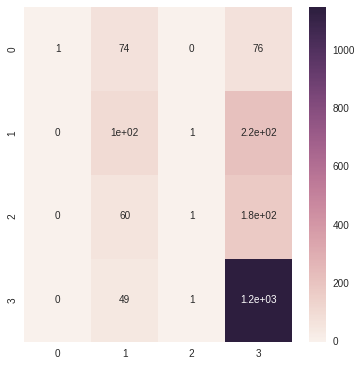

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:35:57.683175. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [139]:
# convert to a dataframe
df_cm = pd.DataFrame(confusion_mc,
                     index = [i for i in range(0,4)],
                     columns = [i for i in range(0,4)])
# plot graph
plt.figure(figsize=(6,6)) # define graph
sns.heatmap(df_cm, annot=True) # draw heatmap, add annotation

In [140]:
unique_elements, counts_elements = np.unique(prediction_validation, return_counts=True)
print(unique_elements)
print(counts_elements)

[1 2 3 4]
[   1  283    3 1625]


/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:35:58.019733. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [141]:
from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2', 'class 3', 'class 4']
print(classification_report(prediction_validation, y_validation, target_names=target_names))

             precision    recall  f1-score   support

    class 1       0.01      1.00      0.01         1
    class 2       0.31      0.35      0.33       283
    class 3       0.00      0.33      0.01         3
    class 4       0.96      0.71      0.81      1625

avg / total       0.86      0.65      0.74      1912



/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:35:59.917120. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


## Balanced datasets - ADASYN

In [142]:
ada = ADASYN()
X_ada, y_ada = ada.fit_sample(train[categorical_columns], train["Target"])

print(X_ada.shape, y_ada.shape)

X_ada_train, X_ada_validation, y_ada_train, y_ada_validation = train_test_split(X_ada, y_ada, test_size=0.2, stratify=y_ada)

prediction_ada_train, prediction_ada_validation = logistic_regression_prediction(1e7, X_ada_train, y_ada_train, X_ada_validation)

((23842, 102), (23842,))


/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:36:01.486552. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [143]:
accuracy, precision, recall, f1 = all_score(y_ada_validation, prediction_ada_validation)
print_score(accuracy, precision, recall, f1)

('Accuracy:', 0.4061648144265045)
('Precision:', 0.3988932875569695)
('Recall:', 0.406018720303006)
('F1:', 0.3968554765115062)


/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:36:25.141246. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


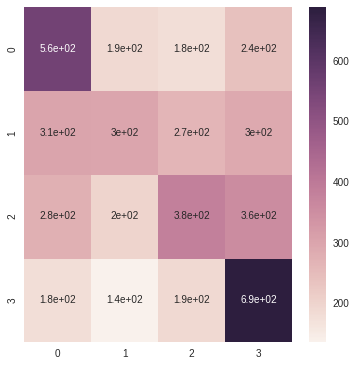

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:36:34.304607. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [144]:
confusion_mc = confusion_matrix(y_ada_validation, prediction_ada_validation)
# print confusion_mc

# convert to a dataframe
df_cm = pd.DataFrame(confusion_mc,
                     index = [i for i in range(0,4)],
                     columns = [i for i in range(0,4)])
# plot graph
plt.figure(figsize=(6,6)) # define graph
sns.heatmap(df_cm, annot=True) # draw heatmap, add annotation

## Balanced datasets - SMOTE

In [145]:
smo = SMOTE(kind="svm")
X_resampled, y_resampled = smo.fit_sample(train[categorical_columns], train["Target"])

X_smo_train, X_smo_validation, y_smo_train, y_smo_validation = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled)

prediction_smo_train, prediction_smo_validation = logistic_regression_prediction(1e7, X_smo_train, y_smo_train, X_smo_validation)

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:36:38.655014. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [146]:
accuracy, precision, recall, f1 = all_score(y_smo_validation, prediction_smo_validation)
print_score(accuracy, precision, recall, f1)

('Accuracy:', 0.5518032103397957)
('Precision:', 0.5476687415798134)
('Recall:', 0.5517865582429803)
('F1:', 0.5476501965062087)


/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:37:48.019198. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


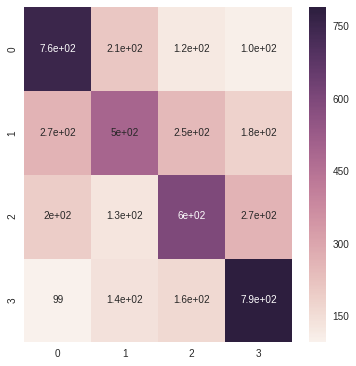

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:37:52.963260. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [147]:
confusion_mc = confusion_matrix(y_smo_validation, prediction_smo_validation)
# print confusion_mc

# convert to a dataframe
df_cm = pd.DataFrame(confusion_mc,
                     index = [i for i in range(0,4)],
                     columns = [i for i in range(0,4)])
# plot graph
plt.figure(figsize=(6,6)) # define graph
sns.heatmap(df_cm, annot=True) # draw heatmap, add annotation

In [148]:
from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2', 'class 3', 'class 4']
print(classification_report(prediction_smo_validation, y_smo_validation, target_names=target_names))

             precision    recall  f1-score   support

    class 1       0.63      0.57      0.60      1324
    class 2       0.41      0.50      0.45       984
    class 3       0.50      0.53      0.51      1142
    class 4       0.66      0.59      0.62      1347

avg / total       0.56      0.55      0.56      4797



/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:37:57.295427. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


## Hyper-parameters tuning

In [149]:
reg_params = [1e-7, 0.000001, 0.00001, 0.0001, 0.001,0.01,0.1,1,10,100,1000]
accuracy_scores = {"train": [], "validation": []}
precision_scores = {"train": [], "validation": []}
recall_scores = {"train": [], "validation": []}
f1_scores = {"train": [], "validation": []}
print("Number of neighbor: "),
for reg_param in reg_params:
    print(", {0}".format(reg_param)),
    prediction_smo_train, prediction_smo_validation = logistic_regression_prediction(reg_param, X_smo_train, y_smo_train, X_smo_validation)
    accuracy, precision, recall, f1 = all_score(y_smo_train, prediction_smo_train)
    accuracy_scores["train"].append(accuracy)
    precision_scores["train"].append(precision)
    recall_scores["train"].append(recall)
    f1_scores["train"].append(f1)  
    
    accuracy, precision, recall, f1 = all_score(y_smo_validation, prediction_smo_validation)
    accuracy_scores["validation"].append(accuracy)
    precision_scores["validation"].append(precision)
    recall_scores["validation"].append(recall)    
    f1_scores["validation"].append(f1)

Number of neighbor:  , 1e-07 , 1e-06 , 1e-05 , 0.0001 , 0.001 , 0.01 , 0.1 , 1 , 10 , 100 , 1000


/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:38:13.520449. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [150]:
regs = [1/reg for reg in reg_params]
regs

[10000000.0,
 1000000.0,
 99999.99999999999,
 10000.0,
 1000.0,
 100.0,
 10.0,
 1.0,
 0.1,
 0.01,
 0.001]

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:38:53.137222. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


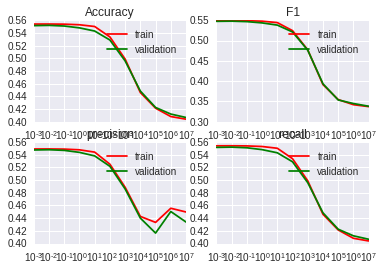

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:38:55.099250. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [151]:
fig, ax = plt.subplots(nrows=2, ncols=2)

ax[0][0].semilogx(regs, accuracy_scores["train"], c="r", label="train")
ax[0][0].semilogx(regs, accuracy_scores["validation"], c="g", label="validation")
ax[0][0].set_title("Accuracy")
ax[0][0].legend()

ax[0][1].semilogx(regs, f1_scores["train"], c="r", label="train")
ax[0][1].semilogx(regs, f1_scores["validation"], c="g", label="validation")
ax[0][1].set_title("F1")
ax[0][1].legend()

ax[1][0].semilogx(regs, precision_scores["train"], c="r", label="train")
ax[1][0].semilogx(regs, precision_scores["validation"], c="g", label="validation")
ax[1][0].set_title("precision")
ax[1][0].legend()

ax[1][1].semilogx(regs, recall_scores["train"], c="r", label="train")
ax[1][1].semilogx(regs, recall_scores["validation"], c="g", label="validation")
ax[1][1].set_title("recall")
ax[1][1].legend()

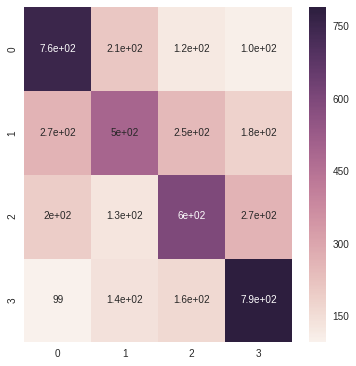

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:48:55.617234. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [154]:
nearest_neighbors = LogisticRegression(C=1000)
model = nearest_neighbors.fit(X_smo_train, y_smo_train)
prediction_smo_validation = model.predict(X_smo_validation)


# print confusion_mc

# convert to a dataframe
df_cm = pd.DataFrame(confusion_mc,
                     index = [i for i in range(0,4)],
                     columns = [i for i in range(0,4)])
# plot graph
plt.figure(figsize=(6,6)) # define graph
sns.heatmap(df_cm, annot=True) # draw heatmap, add annotation

In [155]:
from sklearn.metrics import classification_report
target_names = ['class 1', 'class 2', 'class 3', 'class 4']
print(classification_report(prediction_smo_validation, y_smo_validation, target_names=target_names))

             precision    recall  f1-score   support

    class 1       0.63      0.57      0.60      1324
    class 2       0.41      0.50      0.45       984
    class 3       0.50      0.53      0.51      1143
    class 4       0.66      0.59      0.62      1346

avg / total       0.56      0.55      0.56      4797



/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:49:02.523907. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [156]:
prediction_kaggle = model.predict(test[categorical_columns])

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:49:02.532249. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [157]:
unique_elements, counts_elements = np.unique(prediction_kaggle, return_counts=True)
print(unique_elements)
print(counts_elements)

[1 2 3 4]
[ 3411  4194  3907 12344]


/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:49:02.560338. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [158]:
id_kaggle = test["Id"]

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:49:02.567922. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [159]:
d = {"Id": id_kaggle, "Target": prediction_kaggle}
data = pd.DataFrame(d)

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:49:02.574450. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [160]:
data.head(5)

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,4


/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:49:05.318742. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [161]:
data.to_csv("/home/mahjoubi/Documents/github/costa_rican_household_poverty/submission/sklearn/smote/logisticRegression.csv", index=False)

/home/mahjoubi/anaconda2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-08-30 14:49:06.314343. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)
